## Plotting real trigger data for the Borrego Springs and Berkeley events

In [1]:
import obspy as op
from obspy.clients.fdsn import Client 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from util import filter_rt
import pickle
import numpy as np
%matplotlib inline

In [2]:
plt.style.use('seaborn-poster')

In [3]:
eqloc_sC = [33.432,-116.443]
eqloc_nC = [37.855,-122.257]

 ## For the Borrego Springs event
 
 The file 'Borrego_Springs.csv' contains all the real triggers that occured in the Borrego Springs simulation.
 See Simulate.py, line 350
 
 Here we load these triggers, get the event information and then plot simulated triggers vs. real triggers 

In [4]:
phone_pga = pd.read_csv("Borrego_Springs.csv")
phone_pga['triggerTime'] = pd.to_datetime(phone_pga['triggerTime'])
phone_pga.reset_index(inplace=True,drop=True)

In [5]:
#Get the origin time of the event 
client = Client("IRIS")
starttime = '2016-01-01'
endtime = '2016-12-01'
minlatitude = 32
maxlatitude = 36
minlongitude=-122
maxlongitude=-115
minmag = 5
quake_catalog = client.get_events(starttime=op.UTCDateTime(starttime),endtime=op.UTCDateTime(endtime),\
                    minlatitude=minlatitude,maxlatitude=maxlatitude,minlongitude=minlongitude,maxlongitude=maxlongitude,minmagnitude=minmag)

In [6]:
otime = pd.to_datetime(str(quake_catalog[0].origins[0].time))

In [7]:
otime

Timestamp('2016-06-10 08:04:38.700000')

In [8]:
phone_pga['time_since_otime'] = phone_pga['triggerTime'].apply(lambda x: (x - otime).total_seconds())

In [9]:
phone_pga.head()

,triggerTime,latitude,longitude,pga,corrected,p_flag,time_since_otime
0,2016-06-10 08:02:38.029,34.014690,-118.327976,0.012738,1,0.0,-120.671
1,2016-06-10 08:02:50.620,33.499714,-112.200865,0.490784,0,0.0,-108.080
2,2016-06-10 08:03:06.657,34.247449,-118.607106,0.005833,1,1.0,-92.043
3,2016-06-10 08:03:13.799,34.076339,-117.169994,0.008309,1,1.0,-84.901
4,2016-06-10 08:03:29.787,33.763762,-118.147672,0.001102,0,0.0,-68.913


In [10]:
def calc_distance(row):
    
    '''Determine distance in km between phone and known epicenter'''
    
    return op.geodetics.gps2dist_azimuth(eqloc[0],eqloc[1],row['latitude'],row['longitude'])[0]/1000.0

In [11]:
#Determine distance from event
eqloc = eqloc_sC
phone_pga['epidistance'] = phone_pga.apply(calc_distance,axis=1)

In [12]:
def convert_distance(depth,distance,vp,vs):
    
    traveldist = np.sqrt(depth**2+distance**2)
    vp_t = traveldist/vp
    vs_t = traveldist/vs
    
    return (distance,vp_t), (distance,vs_t)

In [13]:
(d0,pt0), (d0,st0) = convert_distance(10,0,6.1,3.55)
(d1,pt1), (d1,st1) = convert_distance(10,200,6.1,3.55)

In [14]:
print(d0,pt0)
print(d1,pt1)

0 1.6393442623
200 32.8278432697


This file was generated by a simulation with 0.1% of the population. Different simulations will produce slightly different results

In [16]:
simulated_triggers = pd.read_csv('Trigger_list_BSprings_test_1.csv')

In [17]:
simulated_triggers.head()

,datetime,latitude,longitude,dist,delta_t,pga,p_flag
0,2016-06-10 08:04:59.855557+00:00,32.814111,-116.959612,83.847471,21.155557,0.010002,0
1,2016-06-10 08:05:14.410798+00:00,32.428243,-116.973598,122.066477,35.710798,0.010023,0
2,2016-06-10 08:05:00.974207+00:00,34.119237,-116.453726,76.479750,22.274207,0.010028,0
3,2016-06-10 08:05:08.311176+00:00,32.488383,-116.837068,111.137816,29.611176,0.010035,0
4,2016-06-10 08:05:06.037552+00:00,34.116341,-117.322503,111.409683,27.337552,0.010050,1


### Plotting figure for the paper

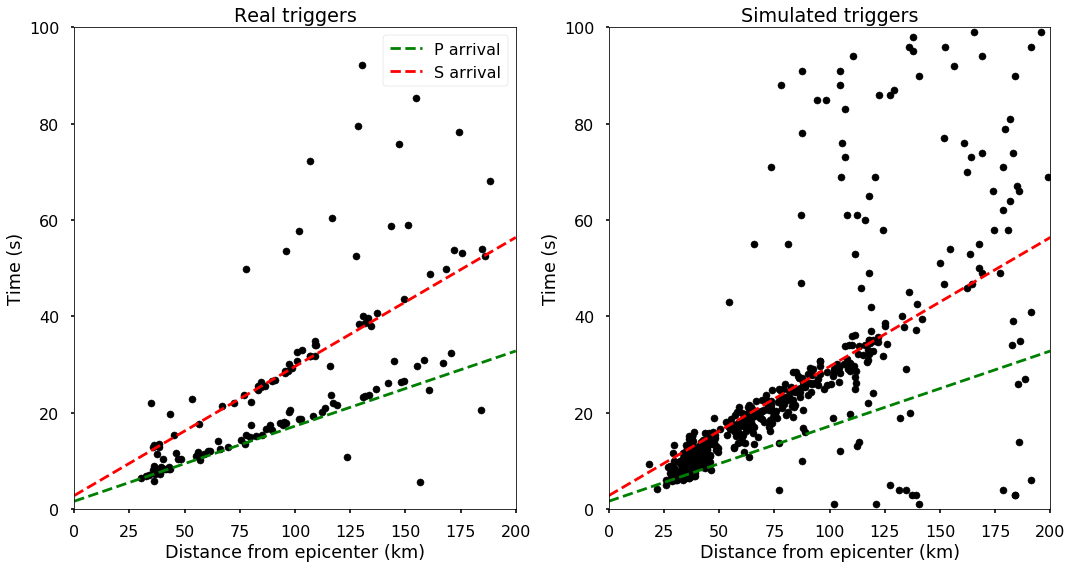

In [21]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

phone_pga.plot(kind='scatter',x='epidistance',y='time_since_otime',ax=ax1,s=50,c='k')
ax1.plot((d0,d1),(pt0,pt1),'g--',label='P arrival')
ax1.plot((d0,d1),(st0,st1),'r--',label='S arrival')
ax1.legend(loc='best')

ax1.set_xlabel('Distance from epicenter (km)')
ax1.set_ylabel('Time (s)')
ax1.set_xlim([0,200])
ax1.set_ylim([0,100])
ax1.set_title('Real triggers')

simulated_triggers.plot(kind='scatter',x='dist',y='delta_t',ax=ax2,s=50,c='k')
ax2.plot((d0,d1),(pt0,pt1),'g--',label='P arrival')
ax2.plot((d0,d1),(st0,st1),'r--',label='S arrival')
ax2.set_xlabel('Distance from epicenter (km)')
ax2.set_ylabel('Time (s)')
ax2.set_xlim([0,200])
ax2.set_ylim([0,100])
ax2.set_title('Simulated triggers')

plt.tight_layout()
plt.savefig('Real_vs_simulated_triggers_borrego.pdf',dpi=200)

### Exploration of the phones whose PGA values are corrected vs uncorrected 

In [19]:
corrected_phones = phone_pga[phone_pga['corrected']==1]
uncorrected_phones = phone_pga[phone_pga['corrected']==0]

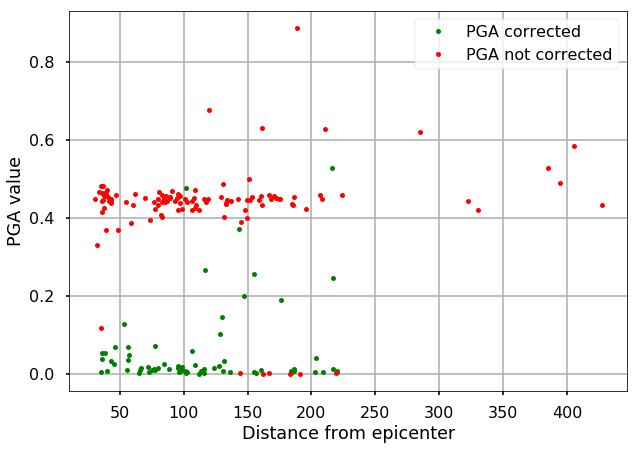

In [20]:
fig = plt.figure(figsize=(10,7))
plt.plot(corrected_phones['epidistance'],corrected_phones['pga'],'go',markersize=5,label='PGA corrected')
plt.plot(uncorrected_phones['epidistance'],uncorrected_phones['pga'],'ro',markersize=5,label='PGA not corrected')
plt.xlabel('Distance from epicenter')
plt.ylabel('PGA value')
plt.legend(loc='best')
plt.grid()
plt.savefig("Borrego_triggers_PGA.png",dpi=150)

/home/rmartinshort/anaconda2/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


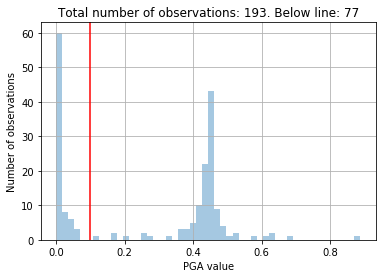

In [76]:
sns.distplot(phone_pga['pga'],kde=False,bins=50)
plt.grid()
plt.xlabel('PGA value')
plt.ylabel('Number of observations')
plt.title('Total number of observations: %i. Below line: %i' %(len(phone_pga),len(phone_pga[phone_pga['pga']<0.1])))
plt.axvline(0.1,color='r')
plt.savefig("Borrego_triggers_dist.png",dpi=150)

### Extracting infromation from the waveforms

In [84]:
waveforms = "/home/rmartinshort/Documents/Berkeley/MyShake_simulations/rms_version/clustering_compare/MyShake_simulation/data/Good_earthquakes/20160610T000000_20160611T000000/20km_NNW_of_Borrego_Springs,_CA_M5.17/data"

In [85]:
all_waveforms = list(sorted(glob.glob(waveforms+'/*.pkl')))
filter_hp = filter_rt.filter_rt()

In [86]:
pga_vals = []

for waveform in all_waveforms:
    
    data = pickle.load(open(waveform,'rb'), encoding='latin1')
    tt = data['triggerTimer']
    ts = data['data']['ts']
    x = data['data']['x']
    y = data['data']['y']
    z = data['data']['z']
    dt = np.diff(ts/1000.)
    x1, y1, z1 = filter_hp.apply_filter(x,y,z,dt)
    ix = (ts >=(tt - 100)) & (ts<= tt+100) #not clear about what interval to use here
    try:
        pga = np.max([np.abs(x1[ix]), np.abs(y1[ix]), np.abs(z1[ix])])
        pga_vals.append(pga)
    except:
        print("Could not extract pga")
        pga_vals.append(np.nan)

Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not extract pga
Could not 

In [89]:
pga_vals = np.array(pga_vals)
print(sum(np.isnan(pga_vals))/len(pga_vals)) #proportion of data that did not get sampled
len(pga_vals)

0.13606557377


610

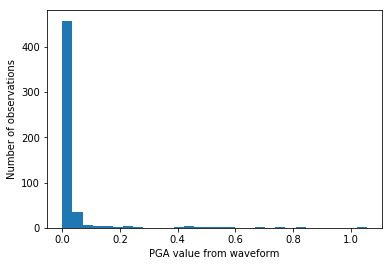

In [90]:
plt.hist(pga_vals[~np.isnan(pga_vals)],bins=30)

plt.xlabel('PGA value from waveform')
plt.ylabel('Number of observations')
plt.savefig("Borrego_from_phone_dist.png",dpi=150)

## For the Berkeley event

In [145]:
#Get the origin time of the event 
client = Client("IRIS")
starttime = '2018-01-01'
endtime = '2018-12-01'
minlatitude = 35
maxlatitude = 39
minlongitude=-124
maxlongitude=-119
minmag = 4
quake_catalog = client.get_events(starttime=op.UTCDateTime(starttime),endtime=op.UTCDateTime(endtime),\
                    minlatitude=minlatitude,maxlatitude=maxlatitude,minlongitude=minlongitude,maxlongitude=maxlongitude,minmagnitude=minmag)

In [146]:
quake_catalog

6 Event(s) in Catalog:
2018-11-27T13:07:12.830000Z | +36.074, -120.188 | 4.0 Mw
2018-11-02T12:58:54.230000Z | +36.680, -121.315 | 4.3285 Mw
2018-05-10T02:58:30.910000Z | +38.810, -122.797 | 4.19 Mw
2018-04-16T16:36:48.880000Z | +35.044, -119.042 | 4.1 ML
2018-01-18T05:55:11.950000Z | +38.785, -122.743 | 4.22 mw
2018-01-04T10:39:37.730000Z | +37.855, -122.257 | 4.38 Mw

In [147]:
phone_pga = pd.read_csv("Berkeley.csv")
#Convert to datetime
phone_pga['triggerTime'] = pd.to_datetime(phone_pga['triggerTime'])
phone_pga.reset_index(inplace=True)

In [148]:
#Determine distance from event
eqloc = eqloc_nC
phone_pga['epidistance'] = phone_pga.apply(calc_distance,axis=1)

In [149]:
otime = pd.to_datetime(str(quake_catalog[-1].origins[0].time))

In [150]:
corrected_phones = phone_pga[phone_pga['corrected']==1]
uncorrected_phones = phone_pga[phone_pga['corrected']==0]

In [151]:
phone_pga['time_since_otime'] = phone_pga['triggerTime'].apply(lambda x: (x - otime).total_seconds())

In [152]:
phone_pga.head()

,index,triggerTime,latitude,longitude,pga,corrected,p_flag,epidistance,time_since_otime
0,0,2018-01-04 10:39:18.681,38.663052,-120.999146,0.595156,1,1.0,142.001288,-19.049
1,1,2018-01-04 10:39:41.133,37.899904,-122.304039,0.453306,0,0.0,6.478218,3.403
2,2,2018-01-04 10:39:42.080,37.886772,-122.286497,0.008862,1,0.0,4.378529,4.350
3,3,2018-01-04 10:39:42.127,37.770128,-122.157297,0.451124,0,0.0,12.877039,4.397
4,4,2018-01-04 10:39:42.293,37.840889,-122.249446,0.106888,1,0.0,1.701545,4.563


In [155]:
phone_pga.sort_values(by='time_since_otime')

,index,triggerTime,latitude,longitude,pga,corrected,p_flag,epidistance,time_since_otime
0,0,2018-01-04 10:39:18.681,38.663052,-120.999146,0.595156,1,1.0,142.001288,-19.049
1,1,2018-01-04 10:39:41.133,37.899904,-122.304039,0.453306,0,0.0,6.478218,3.403
2,2,2018-01-04 10:39:42.080,37.886772,-122.286497,0.008862,1,0.0,4.378529,4.350
3,3,2018-01-04 10:39:42.127,37.770128,-122.157297,0.451124,0,0.0,12.877039,4.397
4,4,2018-01-04 10:39:42.293,37.840889,-122.249446,0.106888,1,0.0,1.701545,4.563
5,5,2018-01-04 10:39:42.499,37.867494,-122.275135,0.082796,1,1.0,2.114197,4.769
6,6,2018-01-04 10:39:42.925,37.881328,-122.276141,0.135305,0,0.0,3.372841,5.195
7,7,2018-01-04 10:39:43.273,37.879068,-122.290305,0.069141,1,1.0,3.965409,5.543
8,8,2018-01-04 10:39:43.353,37.810624,-122.253316,0.113979,1,0.0,4.936094,5.623
9,9,2018-01-04 10:39:43.449,37.813644,-122.268960,0.058916,1,0.0,4.709419,5.719


In [153]:
simulated_triggers = pd.read_csv('Trigger_list_Berkeley_test_1.csv')

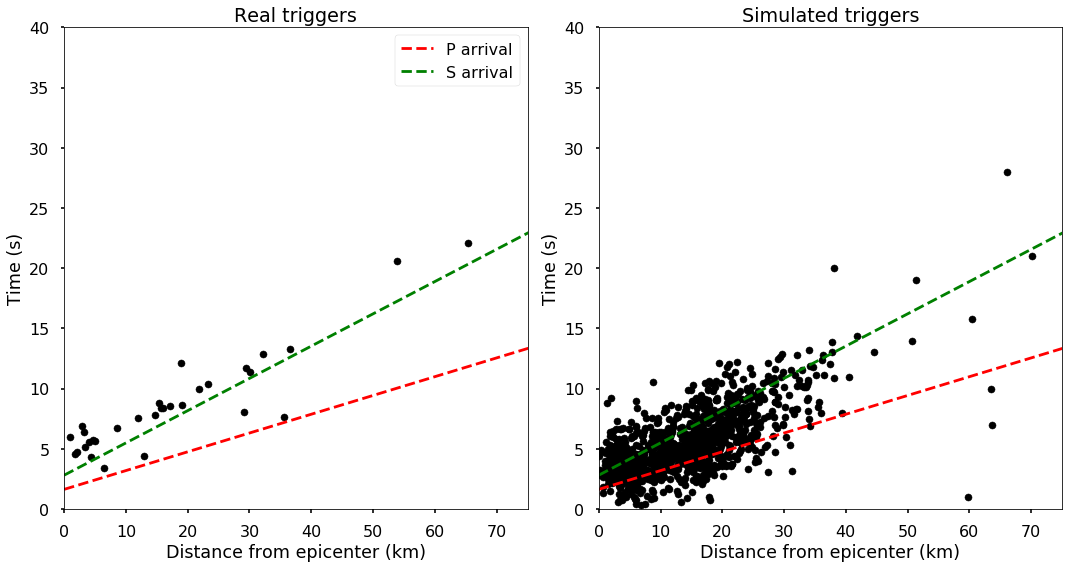

In [154]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

phone_pga.plot(kind='scatter',x='epidistance',y='time_since_otime',ax=ax1,s=50,c='k')
ax1.plot((d0,d1),(pt0,pt1),'r--',label='P arrival')
ax1.plot((d0,d1),(st0,st1),'g--',label='S arrival')
ax1.legend(loc='best')

ax1.set_xlabel('Distance from epicenter (km)')
ax1.set_ylabel('Time (s)')
ax1.set_xlim([0,75])
ax1.set_ylim([0,40])
ax1.set_title('Real triggers')

simulated_triggers.plot(kind='scatter',x='dist',y='delta_t',ax=ax2,s=50,c='k')
ax2.plot((d0,d1),(pt0,pt1),'r--',label='P arrival')
ax2.plot((d0,d1),(st0,st1),'g--',label='S arrival')
ax2.set_xlabel('Distance from epicenter (km)')
ax2.set_ylabel('Time (s)')
ax2.set_xlim([0,75])
ax2.set_ylim([0,40])
ax2.set_title('Simulated triggers')

plt.tight_layout()
plt.savefig('Real_vs_simulated_triggers_berkeley.pdf',dpi=200)

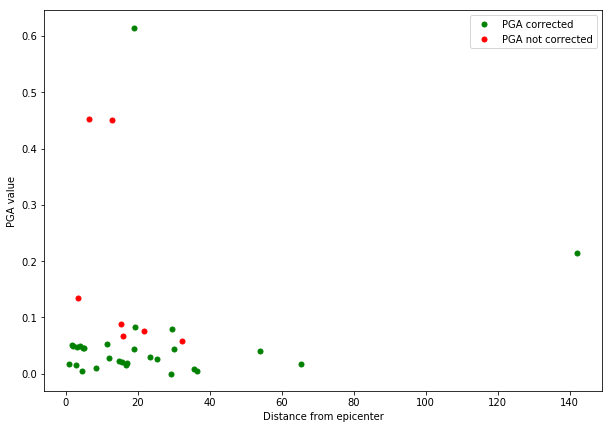

In [81]:
fig = plt.figure(figsize=(10,7))
plt.plot(corrected_phones['epidistance'],corrected_phones['pga'],'go',markersize=5,label='PGA corrected')
plt.plot(uncorrected_phones['epidistance'],uncorrected_phones['pga'],'ro',markersize=5,label='PGA not corrected')
plt.xlabel('Distance from epicenter')
plt.ylabel('PGA value')
plt.legend(loc='best')
plt.savefig("Berkeley_triggers_PGA.png",dpi=150)

/home/rmartinshort/anaconda2/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


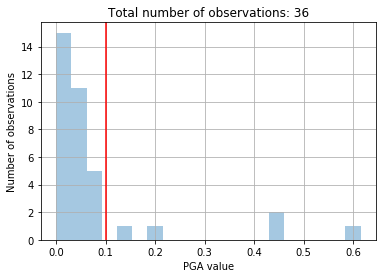

In [82]:
sns.distplot(phone_pga['pga'],kde=False,bins=20)
plt.grid()
plt.xlabel('PGA value')
plt.ylabel('Number of observations')
plt.title('Total number of observations: %i' %len(phone_pga))
plt.axvline(0.1,color='r')
plt.savefig("Berkeley_triggers_dist.png",dpi=150)

### Extract from the waveforms

In [54]:
waveforms = "/home/rmartinshort/Documents/Berkeley/MyShake_simulations/rms_version/clustering_compare/MyShake_simulation/data/Good_earthquakes/20180104T000000_20180105T000000/2km_SE_of_Berkeley,_CA_M4.38/data"

In [55]:
all_waveforms = list(sorted(glob.glob(waveforms+'/*.pkl')))
filter_hp = filter_rt.filter_rt()

In [58]:
pga_vals = []

for waveform in all_waveforms:
    
    data = pickle.load(open(waveform,'rb'), encoding='latin1')
    tt = data['triggerTimer']
    ts = data['data']['ts']
    x = data['data']['x']
    y = data['data']['y']
    z = data['data']['z']
    dt = np.diff(ts/1000.)
    x1, y1, z1 = filter_hp.apply_filter(x,y,z,dt)
    ix = (ts >=(tt - 100)) & (ts<= tt+100) #not clear about what interval to use here
    try:
        pga = np.max([np.abs(x1[ix]), np.abs(y1[ix]), np.abs(z1[ix])])
        pga_vals.append(pga)
    except:
        print("Could not extract pga")
        pga_vals.append(np.nan)

Could not extract pga


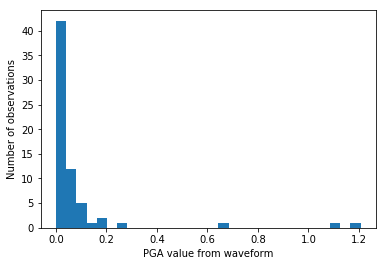

In [83]:
pga_vals = np.array(pga_vals)
plt.hist(pga_vals[~np.isnan(pga_vals)],bins=30)
plt.xlabel('PGA value from waveform')
plt.ylabel('Number of observations')
plt.savefig("Berkeley_from_phone_dist.png",dpi=150)